In [2]:
import os 
import re
import torch 
import librosa 
import scipy.signal as sig 
import soundfile as sf
import numpy as np
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, WhisperProcessor, WhisperForConditionalGeneration

/Users/doanhnguyen/anaconda3/envs/CSE156/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# wv2_base_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
# wv2_base_proc = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# wv2_large_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
# wv2_large_proc = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

In [3]:
whisper_large_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large-v3-turbo")
whisper_large_proc = WhisperProcessor.from_pretrained("openai/whisper-large-v3-turbo")

In [3]:
wav_path_kid = '/home/cogsci-lasrlab/Documents/FANN/K1_wav_kid'
wav_path_adult = '/home/cogsci-lasrlab/Documents/FANN/K1_wav_adult'

In [ ]:
hotwords = {
    'ring': ['ring', 'wing', 'thumb', 'sun'],
    'wing': ['wing', 'ring', 'sun', 'thumb'],
    'thumb': ['thumb', 'sun', 'ring', 'wing'],
    'sun': ['thumb', 'sun', 'ring', 'wing', 'son'], 
    'fan': ['fan', 'sand', 'red', 'leg'], 
    'sand': ['fan', 'sand', 'red', 'leg'], 
    'red': ['fan', 'sand', 'red', 'leg'],
    'leg': ['fan', 'sand', 'red', 'leg'], 
    'chip': ['chip', 'ship', 'run', 'one'],
    'ship': ['chip', 'ship', 'run', 'one'],
    'run': ['chip', 'ship', 'run', 'one'],
    'one': ['chip', 'ship', 'run', 'one', 'won'],
    'window': ['window', 'fox', 'socks', 'rainbow'], 
    'rainbow': ['window', 'fox', 'socks', 'rainbow'], 
    'fox': ['window', 'fox', 'socks', 'rainbow', 'sox'], 
    'socks': ['window', 'fox', 'socks', 'rainbow', 'sox'], 
    'ramp': ['ramp', 'shoe', 'zoo', 'lamp'],
    'lamp': ['ramp', 'shoe', 'zoo', 'lamp'],
    'shoe': ['ramp', 'shoe', 'zoo', 'lamp', 'shoo', 'shue'],
    'zoo': ['ramp', 'shoe', 'zoo', 'lamp'],
    'chick': ['chick', 'sick', 'rock', 'lock'], 
    'sick': ['chick', 'sick', 'rock', 'lock'], 
    'rock': ['chick', 'sick', 'rock', 'lock'], 
    'lock': ['chick', 'sick', 'rock', 'lock', 'loch', 'locke'], 
}

In [4]:
whisper_vocab_dict = whisper_large_proc.tokenizer.get_vocab()
sorted_whisper_vocab_dict = {k.replace('Ġ', ' '): v for k, v in sorted(whisper_vocab_dict.items(), key = lambda item: item[1])}

In [5]:
def clean(text):
    text = re.sub(r'\<\|[^)]*?\|\>', '', text).strip()
    text = re.sub(r'-.!', '', text).strip()
    text = re.sub(r"[^\w\s]", "", text).strip()
    text = text.replace('(', '')
    text = text.replace('\n', '')
    text = text.replace(')', '')
    text = text.replace('?', '')
    text = text.lower()
    text = text.encode('ascii', 'ignore').decode('ascii')
    return text

In [6]:
def extract_target_word(filename):
    parts = filename.split('_')
    target_part = parts[-1]
    target_word = target_part.split('.')[0]
    
    return target_word

In [ ]:
from pyctcdecode import build_ctcdecoder

def preprocess(target):
    count = 0 
    new_dict = {}
    for k, v in sorted_whisper_vocab_dict.items():
        for h in hotwords[target]:
            if h in k or h.upper() in k.upper() or h.lower() in k.lower():
                count += 1
                new_dict[k] = v
            
            if len(k) < 2 or '<|' in k:
                count += 1
                new_dict[k] = v
    
    ind_list = [v for v in new_dict.values()]
    decoder = build_ctcdecoder(list(new_dict.keys()), kenlm_model_path = None) 
    norm_decoder = build_ctcdecoder(list(new_dict.keys()), kenlm_model_path = None)
    
    return ind_list, decoder, norm_decoder

ModuleNotFoundError: No module named 'pyctcdecode'

In [ ]:
audio_files = [
    "k1ay244participant_shoe.wav",
    "k1ay244participant_socks.wav",
    "k1cb011participant_shoe.wav",
    "k1cb011participant_thumb.wav",
    "k1cb011participant_ship.wav",
    "k1cb024participant_rainbow.wav",
    "k1cb024participant_lock.wav",
    "k1cb024participant_socks.wav",
    "k1cb103participant_socks.wav",
    "k1cb103participant_ship.wav",
    "k1cb103participant_shoe.wav",
    "k1cb116participant_socks.wav",
    "k1cb116participant_rock.wav",
    "k1cb116participant_shoe.wav",
    "k1cb116participant_red.wav",
    "k1cb128participant_shoe.wav",
    "k1cb128participant_leg.wav",
    "k1cb128participant_socks.wav",
    "k1cb132participant_socks.wav",
    "k1cb132participant_ship.wav",
    "k1cb132participant_shoe.wav",
    "k1cc014participant_fan.wav",
    "k1cc014participant_shoe.wav",
    "k1cc023participant_lamp.wav",
    "k1cc023participant_shoe.wav",
    "k1cc035participant_window.wav",
    "k1cc035participant_shoe.wav",
    "k1cc035participant_rainbow.wav",
    "k1cc044participant_fan.wav",
    "k1cc044participant_shoe.wav",
    "k1cc044participant_thumb.wav",
    "k1cc044participant_ship.wav",
    "k1cc044participant_socks.wav",
    "k1cc056participant_socks.wav",
    "k1cc056participant_sick.wav",
    "k1cc067participant_rainbow.wav",
    "k1cc067participant_socks.wav",
    "k1cc067participant_lamp.wav",
    "k1cc067participant_shoe.wav",
    "k1dd073participant_wing.wav",
    "k1dd073participant_socks.wav",
    "k1dd073participant_window.wav",
    "k1dd073participant_ring.wav",
    "k1dd073participant_shoe.wav",
    "k1dd084participant_socks.wav",
    "k1dd092participant_socks.wav",
    "k1dd105participant_ring.wav",
    "k1dd105participant_window.wav",
    "k1dd105participant_rainbow.wav",
    "k1dd105participant_ship.wav",
    "k1dd105participant_wing.wav",
    "k1eb212participant_socks.wav",
    "k1eb212participant_thumb.wav",
    "k1eb212participant_fox.wav",
    "k1eb212participant_lock.wav",
    "k1km243participant_sick.wav",
    "k1km243participant_socks.wav",
    "k1km243participant_window.wav",
    "k1km243participant_thumb.wav",
    "k1km243participant_run.wav",
    "k1lm018participant_zoo.wav",
    "k1lm018participant_socks.wav",
    "k1lm031participant_ring.wav",
    "k1lm031participant_thumb.wav",
    "k1lm031participant_ship.wav",
    "k1lm031participant_socks.wav",
    "k1lm045participant_shoe.wav",
    "k1lm045participant_zoo.wav",
    "k1lm067participant_ring.wav",
    "k1lm067participant_ship.wav",
    "k1lt017participant_lock.wav",
    "k1lt017participant_socks.wav",
    "k1lt021participant_socks.wav",
    "k1lt038participant_thumb.wav",
    "k1lt038participant_ship.wav",
    "k1lt038participant_lamp.wav",
    "k1lt038participant_chip.wav",
    "k1lt045participant_shoe.wav",
    "k1lt045participant_rock.wav",
    "k1lt045participant_ramp.wav",
    "k1lt045participant_socks.wav",
    "k1lt057participant_rock.wav",
    "k1lt057participant_shoe.wav",
    "k1lt112participant_socks.wav",
    "k1lt112participant_sun.wav",
    "k1lt112participant_ship.wav",
    "k1lt112participant_window.wav",
    "k1lt112participant_lock.wav",
    "k1lt121participant_fan.wav",
    "k1lt121participant_window.wav",
    "k1lt121participant_shoe.wav",
    "k1lt121participant_ship.wav",
    "k1lt121participant_ramp.wav",
    "k1lt121participant_chick.wav",
    "k1lt121participant_socks.wav",
    "k1lt133participant_fan.wav",
    "k1lt133participant_thumb.wav",
    "k1lt133participant_shoe.wav",
    "k1lt133participant_sand.wav",
    "k1lt141participant_ring.wav",
    "k1lt141participant_shoe.wav",
    "k1lt141participant_sand.wav",
    "k1lt158participant_shoe.wav",
    "k1lt158participant_lamp.wav",
    "k1lt158participant_ramp.wav",
    "k1lt158participant_socks.wav",
    "k1lt202participant_ramp.wav",
    "k1lt202participant_shoe.wav",
    "k1lt214participant_shoe.wav",
    "k1lt214participant_ramp.wav",
    "k1lt214participant_socks.wav",
    "k1lt225participant_rainbow.wav",
    "k1lt225participant_lamp.wav",
    "k1lt236participant_wing.wav",
    "k1lt247participant_lock.wav",
    "k1lt307participant_ramp.wav",
    "k1lt307participant_lamp.wav",
    "k1lt307participant_ring.wav",
    "k1lt311participant_chip.wav",
    "k1lt311participant_ship.wav",
    "k1lt311participant_lamp.wav",
    "k1lt311participant_socks.wav",
    "k1lt311participant_one.wav",
    "k1lt332participant_socks.wav",
    "k1lt332participant_lamp.wav",
    "k1lt332participant_shoe.wav",
    "k1lt332participant_lock.wav",
    "k1mw013participant_ramp.wav",
    "k1mw013participant_leg.wav",
    "k1mw013participant_shoe.wav",
    "k1pb016participant_fox.wav",
    "k1pb023participant_socks.wav",
    "k1pb023participant_ship.wav",
    "k1pb023participant_sand.wav",
    "k1pb035participant_window.wav",
    "k1pb035participant_shoe.wav",
    "k1pb035participant_lamp.wav",
    "k1pb035participant_sand.wav",
    "k1pb035participant_socks.wav",
    "k1pb212participant_socks.wav",
    "k1pb212participant_thumb.wav",
    "k1pb212participant_shoe.wav",
    "k1pb227participant_chick.wav",
    "k1pb227participant_rainbow.wav",
    "k1pb227participant_window.wav",
    "k1pb304participant_shoe.wav",
    "k1pb304participant_rock.wav",
    "k1pb304participant_socks.wav",
    "k1pb318participant_ring.wav",
    "k1pb318participant_shoe.wav",
    "k1pb318participant_zoo.wav",
    "k1pb318participant_thumb.wav",
    "k1pb318participant_ramp.wav",
    "k1pe044participant_ring.wav",
    "k1pe044participant_shoe.wav",
    "k1pe044participant_thumb.wav",
    "k1pe044participant_lock.wav",
    "k1pe044participant_ramp.wav",
    "k1pe055participant_shoe.wav",
    "k1pe055participant_lock.wav",
    "k1pe055participant_ship.wav",
    "k1pe055participant_wing.wav",
    "k1pe055participant_socks.wav",
    "k1pe088participant_shoe.wav",
    "k1pe088participant_red.wav",
    "k1pe088participant_sun.wav",
    "k1pe125participant_fan.wav",
    "k1pe125participant_shoe.wav",
    "k1pe125participant_socks.wav",
    "k1pe131participant_fan.wav",
    "k1pe131participant_chip.wav",
    "k1pe131participant_shoe.wav",
    "k1pe131participant_sun.wav",
    "k1pe131participant_thumb.wav",
    "k1pe147participant_socks.wav",
    "k1pe147participant_ramp.wav",
    "k1pe147participant_shoe.wav",
    "k1pv016participant_socks.wav",
    "k1pv016participant_rainbow.wav",
    "k1pv016participant_zoo.wav",
    "k1pv023participant_zoo.wav",
    "k1pv023participant_socks.wav",
    "k1pv023participant_ramp.wav",
    "k1pv023participant_ship.wav",
    "k1pv023participant_thumb.wav",
    "k1pv023participant_shoe.wav",
    "k1pv023participant_sand.wav",
    "k1pv038participant_shoe.wav",
    "k1pv038participant_sun.wav",
    "k1pv046participant_zoo.wav",
    "k1pv046participant_lock.wav",
    "k1pv058participant_wing.wav",
    "k1pv058participant_window.wav",
    "k1pv058participant_thumb.wav",
    "k1pv058participant_lock.wav",
    "k1pv058participant_sick.wav",
    "k1sb174participant_chip.wav",
    "k1sb174participant_shoe.wav",
    "k1sb174participant_socks.wav",
    "k1so022participant_chick.wav",
    "k1so022participant_shoe.wav",
    "k1so036participant_leg.wav",
    "k1so036participant_thumb.wav",
    "k1so036participant_shoe.wav",
    "k1so053participant_sick.wav",
    "k1so053participant_wing.wav",
    "k1so053participant_socks.wav",
    "k1so053participant_sun.wav",
    "k1so053participant_thumb.wav",
    "k1so053participant_lock.wav",
    "k1so095participant_shoe.wav",
    "k1so095participant_run.wav",
    "k1so095participant_chick.wav",
    "k1so095participant_socks.wav",
    "k1so104participant_window.wav",
    "k1so104participant_shoe.wav",
    "k1so104participant_thumb.wav",
    "k1so112participant_zoo.wav",
    "k1so112participant_socks.wav",
    "k1so112participant_shoe.wav",
    "k1tk026participant_chip.wav",
    "k1tk026participant_zoo.wav",
    "k1tk026participant_socks.wav",
    "k1wa246participant_sick.wav",
    "k1wa246participant_socks.wav",
    "k1wa246participant_ramp.wav",
    "k1wa246participant_lamp.wav",
    "k1wa246participant_shoe.wav",
    "k1rri01participant_socks.wav",
    "k1rri01participant_ring.wav",
    "k1rri01participant_shoe.wav",
    "k1am166participant_wing.wav",
    "k1am166participant_sun.wav",
    "k1am166participant_shoe.wav"
]

Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 1/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 1.0446834142025905e-05, 'red': 0, 'leg': 0.978103720541246}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.9992068523383133, 'sand': 1.6096702764763713e-06, 'red': 3.8780987682074115e-07, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0010821919188581954, 'sand': 0.07759998111663285, 'red': 0.0008871188202646635, 'leg': 0.0004229179026246723}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0010570096691522376, 'sand': 0.0004585652472844119, 'red': 0.0017081761365918546, 'leg': 0.0015478868517822134}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.9160986345300349}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.0005481279943960166, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0.9999950242996611, 'leg': 3.729163295807659e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.00145090143267576, 'wing': 0.0026973831904301337, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0.0009431146071020447, 'run': 0, 'one': 0.0010313889188123876}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.9995100809035619, 'wing': 0.000488929043748117, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0.0005015908210148915, 'sick': 0, 'rock': 0.045917648309601315, 'lock': 0.0026379790875836967}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.000539421672064475, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}
Error processing file KT0BM522child_walk1.wav: 'walk1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 1.00000000000004, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.438427030055681, 'wing': 0.5543090436454531, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0010727626041678116, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.0009557889636538962, 'ship': 0, 'run': 0.0009615090388341112, 'one': 0.0009917942940417803}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.00102133375076932, 'ring': 0.0009926362480672398, 'sun': 0.0004798310513812609, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 1.0759555880935368e-06, 'lock': 0.999553219054939, 'loch': 2.3946358829943985e-07, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.001068291267040125, 'ship': 0.0009559851668740672, 'run': 0.0009409974380379499, 'one': 0.0009924045691856174}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 1.1861565073369122e-13, 'sun': 1.4771336243431221e-12, 'ring': 0, 'wing': 0, 'son': 1.0000000015722512}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005678951878564198, 'shoe': 0, 'zoo': 0, 'lamp': 0.009997391401534373}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.0006371455716477846, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0.9999999700122223, 'fox': 0, 'socks': 0, 'rainbow': 0}
Error processing file KT0BM522child_chick1.wav: 'chick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.0007325404679061607, 'red': 0.0015923447272881966, 'leg': 0.23954532911111928}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0.0005408908308851097, 'sick': 0.0005360585508828167, 'rock': 0.0005371880132644862, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.0000000000002927, 'socks': 1.1539594492108189e-13, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0012927740502383784, 'sick': 0, 'rock': 0.0005323994763130861, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0006337253245598776, 'zoo': 0.001620580063444288, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.8683103334073465e-11, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0.0004592854253983276, 'sun': 0.0004842444377632078, 'ring': 0, 'wing': 0, 'son': 0.0043230025069169115}
ramp → {'ramp': 1.0000000001360572, 'shoe': 0, 'zoo': 0, 'lamp': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 2/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0009522642374371962, 'sand': 0.0009285269178351124, 'red': 0.0009285122217691836, 'leg': 0.0004542962083881784}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0.0033715196902783535, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.0000000000254374, 'sick': 3.365998403938189e-14, 'rock': 1.2954118086270672e-14, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0.9999999822650212, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.0000000000000389, 'lock': 1.5341663819151453e-13}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.999999994411218e-15, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 1.00000000000004, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0010350840148333775, 'socks': 0.05961625067328824, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.00023222854144793083, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0038624016394383756, 'shoe': 0, 'zoo': 0, 'lamp': 0.11512415575346202}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0.0011650280184620659, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.9999996759323625, 'lock': 1.8629326826703514e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 1.00000000000004, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.9999947548186582, 'shoe': 0, 'zoo': 0, 'lamp': 4.196903103111946e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.0000000000000389, 'ring': 1.823161719409864e-12, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.0000000685152115, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.00000000000004, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.9999999682570948, 'one': 1.1059884004899388e-10}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 1.4742070728848204e-12, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0018704295941910634, 'sand': 0.00046398770498451924, 'red': 0.0009284568752938199, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.0000000002022855, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 1.00000000000004, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.038837428096511e-05, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 6.901103409518512e-10, 'shoe': 0, 'zoo': 0, 'lamp': 1.0000000000137947}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.0010177564716844743, 'ship': 0.0015950774410893812, 'run': 0.0009462895565380866, 'one': 0.0015232120717568803}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0.0005497448432499261, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0012240313201066244, 'zoo': 0.002865460383751048, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.15811530913412383, 'sick': 0.0014272010525396264, 'rock': 0.0009600337600648415, 'lock': 0.0004467908748839384}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0015306142070152804, 'sun': 0.08622722799196812, 'ring': 0, 'wing': 0.00039755612212266704}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0.001459604017992562}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0006297232014487944, 'zoo': 0.0011469144278348311, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.11163850925248155, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0.0004669271665933193, 'sun': 0.0011048461081013925, 'ring': 0, 'wing': 0, 'son': 0.016790289465575026}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0008907884638616114, 'ring': 0, 'wing': 0, 'son': 0.0009386940642696395}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0.0010946618805382177, 'lock': 0.0010776133047527428}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.00000000000004, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}
run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 3/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 3.719693266094449e-11, 'ring': 0.9005829862697514, 'sun': 1.729695095654701e-11, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.9999979734461775, 'zoo': 1.0077618059826647e-06, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0.00046814195426083907}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.0000000000001368}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0005114764967225522, 'zoo': 0.03728394105639917, 'lamp': 0.000507248898428093}
Error processing file KT0BM584child_chick1.wav: 'chick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0005870303833790309, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005587302019770964}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0.004954096758497019, 'one': 0.9950458898350752, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0.0005280271385066251, 'rock': 0.0010720865797395995, 'lock': 0.0010833030348901414}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.9965947195469494, 'sand': 1.56568143447834e-06, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}
Error processing file KT0BM544child_rock1.wav: 'rock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0.0013266303798981109, 'fox': 0, 'socks': 0, 'rainbow': 0.0011219247016399695}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.0005172875247196959, 'ship': 0.009043587411413838, 'run': 0.0004902731998819209, 'one': 0.0010115911554566493}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0011738943240978952, 'wing': 0.0011431570590376043, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0009106915543995475, 'sand': 0, 'red': 0.0009226119518098772, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0001065222456384165, 'zoo': 0.9383213211969134, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 6.209880635237621e-05}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 1.8754112642855744e-08, 'sand': 0.99999952681721, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.001240894371510278, 'wing': 0.0009755118724519892, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0.0004618082510434564, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.004794428938635019, 'ship': 0.11603907197340621, 'run': 0, 'one': 0.0008548524801934299}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.9999986886995842, 'lock': 1.3259018325336847e-06}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0004796048202689056, 'sun': 0.0009532920589984772, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0005302651829826196, 'zoo': 0.0010658555974297009, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.0004681370432820579, 'sand': 0, 'red': 0.00047361757808614874, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.05638716078564246, 'zoo': 0.9191405175991776, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0030246422827744732, 'shoe': 0, 'zoo': 0, 'lamp': 0.21541386266508925}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.9999953508594326, 'wing': 4.701931778434013e-06, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0017890790294755963, 'sick': 0.9763693660254104, 'rock': 2.309473583112004e-05, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 2.1788379421584214e-07, 'sun': 0.9999458382492726, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.002066344279153263, 'sand': 0.0015871382845316906, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 9.466911620607822e-15, 'ring': 0, 'wing': 0, 'son': 0.9999999910796841}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.001715282684002329, 'ring': 0.001639368056642265, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0020635638498512666, 'leg': 0.001567218041764944}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}
sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 4/26 ---

Error processing file KT0BM533child_chick1.wav: 'chick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0004901539863336169, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0.0011217329731353235, 'sick': 0, 'rock': 0.0010662706107030947, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.004294453940454064, 'sun': 0.0009593351170315575, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.7247295366312236, 'sand': 0.0012173799810919457, 'red': 0.00026457493393151487, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.013638731223833304, 'wing': 0.0010896475120981957, 'thumb': 0.0004716026546805007, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0014161903153853985, 'zoo': 0.0012166810226955625, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0010070443638122754, 'sand': 0.0004643436059098656, 'red': 0.0014208329554327177, 'leg': 0.0009501388163604913}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 1.3101744435246706e-12, 'zoo': 1.0000000000087772, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 4.458785232263134e-15, 'leg': 1.000000000032458}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}
Error processing file KT0BM551child_walk1.wav: 'walk1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0.00045304799825136095, 'sun': 0.0016475035748779046, 'ring': 0, 'wing': 0, 'son': 0.005614718817359058}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0.0005133691696204751, 'rock': 0.028631896647032477, 'lock': 0.00136939079341921, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.0029967030252509184, 'ship': 0.0004797658474485594, 'run': 0.0004788705909679484, 'one': 0.0009790878304873037}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.0000000165437597, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0010188199008458847, 'ring': 0, 'wing': 0, 'son': 0.008981858448383019}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.00248406792363522, 'ship': 0.001432764293286909, 'run': 0.0004741081272505723, 'one': 0.0009577756993243555}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.5446304885108607, 'zoo': 0.001295197512765326, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 7.060636613951457e-06, 'wing': 0.997240879161876, 'thumb': 0, 'sun': 2.7709253001911244e-06}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0.00048794794010178794}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.0000000520638859}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.9982190009511298, 'one': 5.819976034387506e-06}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}
Error processing file KT0BM562child_walk1.wav: 'walk1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.9946717820409495, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.05263310888007598}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.000563950492107131, 'zoo': 0.000584696879444404, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.0000000000000389, 'ring': 5.9909638069197454e-12, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 5.778846193957416e-06, 'leg': 0.9989449411235201}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.00760793754195749, 'lock': 0.07117566469789052}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0014081958338423373, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 1.9197816243993727e-07, 'zoo': 0.09546330384153999, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.003815413353151348, 'ship': 0.0015209651659683387, 'run': 0.0009711548331243758, 'one': 0.0020913978569781135}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}
lamp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 5/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.0016035940418503715, 'one': 0.0009935585539178095}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0.9999998807907677, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.03412079869074156, 'shoe': 0, 'zoo': 0, 'lamp': 0.028144721095707363}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0.00027760752952802595, 'red': 0.0008592681257833408, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.000545054334206137, 'sun': 0.0009592283015094686, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.001378135128489778, 'leg': 0.0013975338141987573}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0007515199661243878, 'shoe': 0, 'zoo': 0, 'lamp': 0.000661484858574815}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0012068886093160778, 'socks': 0.001355429715605811, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.0000000274154546, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 6.728502536116602e-12, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.0014263650537308448, 'ship': 0.003310775394852912, 'run': 0.0004750617540105345, 'one': 0.00047849556986270895}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0.00047489007749866396, 'red': 0.0011081039223463963, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0.001114922090451856, 'leg': 0.00047206297890429864}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.0005239689652015426, 'lock': 0.0010466169392972045}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.0014235761010662823, 'lock': 0.001133290585244617}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.06380733004440668, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.0000000000005786, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.0010501008458319273, 'lock': 0.9989499162504094}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.9819693067015773, 'lock': 0.00014760802039885098}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 6.559513270324139e-06, 'lock': 0.9999934496610048}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.0028343952056691176, 'socks': 0.0005582953020375861, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.0000000000000389, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005598089243022062}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0005973040611716721, 'shoe': 0, 'zoo': 0, 'lamp': 0.0006464780887478506}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0.9943208823567111, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.001027475924011334, 'sun': 0.00047671760130935694, 'ring': 0, 'wing': 0}
Error processing file KT0BM584child_lock1.wav: 'lock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.9999999829301859}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.0012427515095551215, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}
ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 6/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 8.618635735983724e-12, 'one': 1.0000000001137774, 'won': 8.500591138289134e-12}
Error processing file KT0BM533child_walk1.wav: 'walk1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.01911264035122297, 'ship': 0.000960049326768428, 'run': 0.0004707855956372994, 'one': 0.0010108360014884506}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.9585272223504652e-06, 'lock': 0.9999980927176693}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}
Error processing file KT0BM562child_lick1.wav: 'lick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0.0011081450918674254}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0021800216079817724, 'sand': 0.0009913723631206298, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.005935419692475115, 'leg': 0.002160324236016393}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.000915779077377536, 'sand': 0.002191921783895358, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.000000000944522, 'sick': 5.2206881133649185e-12, 'rock': 4.567249599986013e-12, 'lock': 2.1575636440914586e-12}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.4408021972945903e-15, 'wing': 1.0000000000000389, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.00012167565767497493, 'sand': 0.8749907021960454, 'red': 0.00012005596688833867, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005532814124296632, 'shoe': 0, 'zoo': 0, 'lamp': 0.0029802041517557874}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0004085966563846919, 'shoe': 0, 'zoo': 0, 'lamp': 0.13029998042871174}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0.0009961530668686973, 'thumb': 0.0004792552755002176}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0020773461328498556, 'ring': 0, 'wing': 0, 'son': 0.0675156152444101}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005253937825671919, 'shoe': 0, 'zoo': 0, 'lamp': 0.0189118186778958}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0.050510815068747196}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0.0010487300543541335, 'rock': 0.000523478493681383, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.001977551830917772, 'sand': 0.0004763765210689598, 'red': 0.0009374958333104948, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0.9911217575373371, 'fox': 0, 'socks': 0, 'rainbow': 9.805450404307155e-06}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.02081280881384937, 'ring': 0.001466816859079097, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0.0103534704235268}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.9961969057904962, 'one': 4.456569271501699e-06}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.00046506066209237165, 'sand': 0, 'red': 0.0009384881108174168, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 1.00000000000004, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0006225116596353622, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}
Error processing file KT0BM551child_lick1.wav: 'lick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0004992037908160378, 'sun': 0, 'ring': 0, 'wing': 0.00048167942704443887}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0020716202164231235, 'wing': 0, 'thumb': 0, 'sun': 0.000952673968919696}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0.0009453098853476239, 'one': 0.0014475043868480003, 'won': 0.0009349759305522445}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0.006226453234435106, 'sick': 0.001291644504100437, 'rock': 0.0010656128070409832, 'lock': 0.0011077564396638666}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 1.000000000000041, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.9259452085452895, 'shoe': 0, 'zoo': 0, 'lamp': 4.721818300743503e-05}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0011457566218474602, 'wing': 0.0011731752633825213, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0005596311720224749, 'shoe': 0, 'zoo': 0, 'lamp': 0.0006462589496426518}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.002908208124566162, 'sand': 0.003187037679474084, 'red': 0.00288008811234685, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}
wing → {'wing': 4.854221824180515e-07, 'ring': 0.9999994066498918, 'sun': 0, 'thumb': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 7/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.0000000000000402, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 9.124099305364692e-06, 'sick': 1.81852338236865e-05, 'rock': 0.007110120303976702, 'lock': 0.9756521538112075, 'loch': 9.174051169245218e-06, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.00092986838399909, 'red': 0.0009708614140513238, 'leg': 0.0019056042166995075}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 2.7671754177218607e-13, 'zoo': 4.714027276291763e-13, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.960652583405491, 'wing': 0.00041642395475719916, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0005330558751530065, 'sick': 0, 'rock': 0.0010312981685217622, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 1.00000000000004, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0.0005280540799706565, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.00048133545959781174, 'ring': 0, 'sun': 0.0004841469795014877, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0006134569596707846, 'zoo': 0.00436500644672809, 'lamp': 0.0005003629558351303, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0.0009382978071959946, 'run': 0.0009392727444853828, 'one': 0.0009791046921796623}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0.0009216539009022559}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.01730126478687952, 'ship': 0.0018031818253130395, 'run': 0.0004739234620954716, 'one': 0.0011013597781216414}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0010987407980079934, 'socks': 0.0006251659762393565, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.00000000000004, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}
Error processing file KT0BM511child_chick1.wav: 'chick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0009185659465815235, 'ring': 0, 'wing': 0, 'son': 0.0010320168943544978}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.9666356723413639, 'lock': 1.897515138371835e-05}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005382715996679288}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005426262944622475}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0006756821860230446, 'leg': 0.2875862489244693}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}
Error processing file KT0BM533child_sick1.wav: 'sick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0005874983125866234, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0008911455035743514, 'ring': 0, 'wing': 0, 'son': 0.0010753487958596614}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.000543754556334701, 'zoo': 0.0013349262651466375, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0005362403222783844, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.9999977350285647, 'shoe': 0, 'zoo': 0, 'lamp': 2.605207052740451e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 6.507448798565825e-10, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.9999977209721681, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.0010538807266884276, 'one': 0.002986178743842015}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.0010068583965567996, 'sand': 0, 'red': 0.0009510410365453294, 'leg': 0.0010683588559530608}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}
sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 8/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005633777305152914, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005555398674903764}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.0000000000012739, 'lock': 1.7447836690384678e-12}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0005286274783200874, 'sun': 0.00109277915298687, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.00223057635045307, 'one': 0.0011410239604569112}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.00046081660261372337, 'sand': 0.0017821826986211815, 'red': 0.00045718362649845105, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0010377390421770177, 'sand': 0.044108509377500514, 'red': 0.0009491631799463177, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0.7916182283255498, 'fox': 0, 'socks': 0, 'rainbow': 0.0005826988021813536}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.0011300811608820902, 'one': 0.02237117713202259}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.4041582284404511, 'socks': 0.0003406693634214826, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.9807800780090937, 'sand': 2.680180778369374e-05, 'red': 5.398086296058242e-06, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005830606350469306}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.003813785637981962, 'ring': 0.003131732121777715, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.007762232370546927, 'one': 0.002384282382815793}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0010576981937126854, 'sand': 0.0010202922133208771, 'red': 0.0009219935802357503, 'leg': 0.000462376735579808}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0004531334014874326, 'leg': 0.001650891464195303}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 6.35871331630674e-09, 'lock': 1.000000000000043, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.001366044791641087, 'sand': 0.0004689818188295289, 'red': 0.0013928704913895504, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0.0005646150974108647, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.0000000000498448, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0006668354124695979, 'shoe': 0, 'zoo': 0, 'lamp': 0.0006513785580596424}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.0011136880905950968, 'one': 0.007621700831075958}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0.0010063776768949215, 'thumb': 0.0004903643827470931}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.8900439264683574, 'socks': 6.930556449894397e-05, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0006701045194809969, 'sun': 0.0009526249443710365, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.0000000010562813, 'leg': 2.4460700887244313e-10}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.0000000000000437, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 6.140455441416241e-11, 'one': 1.0000000360901453}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0.0010965857880936205, 'rock': 0.0038508444277776336, 'lock': 0.02525591335790397, 'loch': 0.0005130388047452672, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0.0017923978741215595, 'fox': 0, 'socks': 0, 'rainbow': 0.06400685878919672}
ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 9/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 4.306727661399642e-15, 'ring': 0, 'wing': 0, 'son': 1.0000000000000389}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 6.452393121812161e-10, 'wing': 1.0000000000000389, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005687257768258043, 'shoe': 0, 'zoo': 0, 'lamp': 0.0010550093934307456}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0004708413842267229, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0011869399245870475, 'socks': 0.0014646118673978033, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0.002222571109046916}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.00105241700491078, 'ring': 0.0004773713572692984, 'sun': 0.0009622129424223838, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.0000000000012714, 'lock': 7.672964446689203e-13}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.14249337703823367, 'socks': 0.0004780624816517197, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0011155215689634234, 'socks': 0.0006127119584426622, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.002820262208888602, 'socks': 0.0007756376747167659, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.0000000000000442, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 2.6213390675335795e-07, 'one': 0.9999982833118654}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 3.700011301960119e-12, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0.0011068147887952826, 'lamp': 0.0005881457948896917}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0.9407681738913897, 'fox': 0, 'socks': 0, 'rainbow': 0}
Error processing file KT0BM573child_chick1.wav: 'chick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.0, 'sun': 2.5939705969541623e-12, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.011914897149014708, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.0005286181518410541, 'red': 0.001195006754995899, 'leg': 0.0019922155053589733}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0.0005341115153877565, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005352720970462703, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005596589254161511}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0005567443564760313, 'zoo': 0.0005390347004069815, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.000495900613267247, 'sand': 0.0026148624980532127, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0005494164814766946, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0.0005096743977154758, 'leg': 0.0009228754071189672}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.000000027163049, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0005350069708349173, 'zoo': 0.0005344218108634278, 'lamp': 0.0005380788765846647}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.0019232595221980351, 'lamp': 0.0005364410838097248}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.0015160691695950772, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0014931809118370431, 'leg': 0.002396887528586748}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.3283273791203665e-07, 'lock': 0.9999998807907318}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.0013274286299014846, 'ship': 0.003682948953923266, 'run': 0.00048051702988022445, 'one': 0.0019168672544171413}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.000000000000041}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}
lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 10/26 ---

Error processing file KT0BM551child_lock1.wav: 'lock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0.0004778742254571606, 'sun': 0.0009656990776831628, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 1.00000000000004, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 4.115374408328027e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.0000000000000404}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.9909645418565554, 'shoe': 0, 'zoo': 0, 'lamp': 0.009035465765484765}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0005430795450646289, 'zoo': 0.0010843244059799049, 'lamp': 0.0005360841127558578}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0.009861655593529455, 'rock': 0.004447297340079037, 'lock': 0.0017811927127783479, 'loch': 0.000567913060510473, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0027235350364969543, 'sand': 0.0004575969470621853, 'red': 0.0009154651261308893, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}
Error processing file KT0BM522child_lick1.wav: 'lick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.0000000000010465, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.0018865884514163561, 'ship': 0.02883530313715349, 'run': 0.00046451811472640576, 'one': 0.0017757096435033009}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005435393945420775, 'shoe': 0, 'zoo': 0, 'lamp': 0.0010648771488241937}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0011869331487589284, 'zoo': 0.031900302208340114, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.001156116826736299, 'socks': 0.0007886982001490083, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.000000000000041}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0.0005234068593659266}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.00048803240724227214, 'ship': 0.0018291616823509283, 'run': 0.00047617212630656766, 'one': 0.0009607559972044347}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 3.524503473329066e-06, 'ship': 0.9999951208465864, 'run': 3.359727576018657e-09, 'one': 2.3733208158944967e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}
Error processing file KT0BM584child_rock1.wav: 'rock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0.9999965497497006, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 4.778754704260116e-12, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0.0001226442432317475, 'rock': 0.214150457518974, 'lock': 0.0003956652742943511}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0.9999999717689588, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 8.115701351253378e-08, 'ship': 0.9999876415862544, 'run': 2.8746278031954415e-08, 'one': 6.038944277972929e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0.9892091094464053, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.00047802851712297847, 'ship': 0, 'run': 0.0004770725747199729, 'one': 0.0010081686887332358}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}
Error processing file KT0BM562child_lock1.wav: 'lock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005339910633371672}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0006268674709941114, 'zoo': 0.001140949124640365, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 8.942828922095582e-06, 'red': 2.730230364450535e-05, 'leg': 0.9805359626222379}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0016713486878633377, 'wing': 0.0015779734715640468, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}
Error processing file KT0BM562child_sick1.wav: 'sick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0.0009309901747777312, 'leg': 0.0009908002511541548}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0005287169704690645, 'sun': 0.0010122560241109285, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 9.652395466654942e-05, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0.001053452206892226, 'rock': 0.0010981913943481447, 'lock': 0.0016173872792520092}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}
Error processing file KT0BM544child_lock1.wav: 'lock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 1.00000000000004, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}
fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 11/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 7.786239356349718e-05, 'zoo': 0.9886315198259611, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0.0005020363666168809, 'sick': 0.001031757330464314, 'rock': 0.045738456296765734, 'lock': 0.0034854887776445374}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0.0004897595611900805, 'red': 0.0015347852990721179, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.7881326127530113, 'ship': 0.00020614479160064106, 'run': 0, 'one': 0.00020965879019032302}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0.008188056810017656, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.5609569178288122, 'zoo': 0.0018710771721602345, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.000000000441953, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.00048248559797405097, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0005498764526630523, 'sick': 0.0005376628712050034, 'rock': 0.0005308014963181709, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0.0005227660813134736, 'sick': 0.0005241146467596362, 'rock': 0.0012532927986735986, 'lock': 0.0010619101358614585, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0005241818788355655, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.9997455046305921, 'ship': 1.6118869161835827e-06, 'run': 1.1862664670792457e-07, 'one': 2.4251789695862914e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.9982005327336115, 'one': 1.983919070826849e-05}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 3.1999999910579426e-14}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.9999976425141973, 'sand': 1.3142632357036675e-08, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.000471420314149583, 'sand': 0.00045563388560894365, 'red': 0.0004579584276849059, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0.0009500240337578807, 'one': 0.005583923078503211, 'won': 0.0009611900686332044}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0008737381256718462, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.000000000000041}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.19469366702925492, 'sick': 0.03985721378784958, 'rock': 0.0008295617518062857, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 1.00000000000004, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0.0010652410349732493, 'sick': 0.013193527351622159, 'rock': 0.0005242088740655937, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.000000000000041}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0.9999996423722806, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 9.434417311350836e-10, 'zoo': 2.6530736665222723e-11, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0010992253745395176, 'sick': 0, 'rock': 0, 'lock': 0.0005245584378186549}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.0012504965932336692, 'one': 0.0009985452283919555}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 3.724610174567304e-06, 'sick': 0, 'rock': 0.9927785620360371, 'lock': 0.00032366418967011553}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0005605295856760645, 'socks': 0.0005519025365531961, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}
Error processing file KT0BM511child_sick1.wav: 'sick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0005622044623008962, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005808669845773732}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 5.495453629594128e-15, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0.9999999995948367, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.0009483761195063878, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.001025239189758225, 'wing': 0.0019994868926142524, 'thumb': 0, 'sun': 0.0009860599358814913}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}
shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 12/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.0000000000006926, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0017737597115205165, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005665033926584006}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.0000000000003169, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 1.2038980382205076e-06, 'ship': 0.9987354609276773, 'run': 6.005348421741785e-07, 'one': 1.1730674996060235e-06}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.001016878523512598, 'ship': 0.0009403160838736341, 'run': 0.0004693858648719788, 'one': 0.0009599779273363935}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}
Error processing file KT0BM511child_lick1.wav: 'lick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0.00225480152455591, 'fox': 0, 'socks': 0, 'rainbow': 0.0011061149926916646}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0.000534117627843944, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 1.1856493602394899e-08, 'sand': 0.9999983881719902, 'red': 7.389773083824538e-08, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.16012024560608082, 'lock': 0.0017762750192331863}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.00047644194592086895, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0005655126133308015, 'shoe': 0, 'zoo': 0, 'lamp': 0.0006752661861531441}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0005348194969546796, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005431896144328021}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0027008235499922945, 'sand': 0.0009644653593204849, 'red': 0.00046499768702648565, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0011241378776893059, 'wing': 0.0004751331154052506, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0.000538262359702839, 'sick': 0.0005254113197693491, 'rock': 0.0005391627174299631, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0.000468466862940411, 'sick': 0.0009473963296981157, 'rock': 0.011932413884587418, 'lock': 0.09397467723555336, 'loch': 0.00047208481383468975, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.00359496056002401, 'one': 0.00047731354315653693}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.000457092094548799, 'sand': 0.0009324097924288176, 'red': 0.00161287040875842, 'leg': 0.004309930540837114}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.9990996508067539, 'wing': 1.6835613377582552e-05, 'thumb': 2.586375705827626e-07, 'sun': 2.58921627521508e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005459454867204082, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005809185049490273}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.0000000008161791, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0.004036178997646532, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0.0019286113760917764, 'lock': 0.18115520519722803, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0.00046950271377838254, 'run': 0, 'one': 0.0009392128907822525}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.002500293056177538, 'wing': 0.0009438838183423135, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0009103852430656339, 'sun': 0.00048219028228125557, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 1.1283267717339732e-10, 'socks': 1.0966656467331238e-10, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}
one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 13/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 6.036943168119431e-09, 'lock': 0.9999996772607478, 'loch': 1.4223783954804406e-09, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0.0005363413330188052, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.00045548139238976287, 'leg': 0.0030569354642800604}
Error processing file KT0BM522child_sick1.wav: 'sick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.006548332101187982, 'sun': 4.0156996653647225e-06, 'ring': 0, 'wing': 4.739469044285487e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 4.110620050176673e-15, 'rock': 3.0477024793953997e-12, 'lock': 1.0000000550079735}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.0009689345869186273, 'ship': 0.004141244383154659, 'run': 0.0004737377393873308, 'one': 0.0009561729001514585}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0012120904056062865, 'sun': 0.0009622148821668204, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.0000000000240166, 'ship': 3.381096135996931e-12, 'run': 1.5958191283504133e-12, 'one': 1.669719032387502e-12}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0006794057947114058}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.002165509387028989, 'lamp': 0.0005256180523335129}
Error processing file KT0BM533child_lick1.wav: 'lick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0010069567258906846, 'zoo': 0.008885604726700434, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.000537401173348146}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0007158447029317898, 'sun': 0.0016731567739256413, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0014410763937660182, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.00000000000004, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}
Error processing file KT0BM573child_sick1.wav: 'sick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 6.333005763028896e-05, 'rock': 0.8822981603865033, 'lock': 0.00013925107262592514, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.9416203288886701, 'lock': 0.000627971563162496}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0005468910316154388, 'zoo': 0.001143544157759876, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0.0009742496380911374, 'sand': 0, 'red': 0.0030834152887516644, 'leg': 0.00045501358735972557}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}
Error processing file KT0BM584child_sick1.wav: 'sick1'
Error processing file KT0BM522child_lock1.wav: 'lock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}
Error processing file KT0BM551child_sick1.wav: 'sick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.0022491828861099994, 'lock': 0.833937228942973}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0004548033945268353, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0.0013122258030580597, 'sick': 0.014166304981130376, 'rock': 0.0010709007684163835, 'lock': 0.0005248804525819044}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.003033932572185126, 'sand': 0.9943526702177623, 'red': 2.6072926686247254e-06, 'leg': 1.2119666101318898e-06}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0006349476264742993, 'sun': 0.0009533373258039306, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 1.49840909139696e-07, 'zoo': 0.9997445565999873, 'lamp': 1.4266469568469312e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.0000000000000409, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}
sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 14/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0.0010549189195076395, 'rock': 0.0011653647654395877, 'lock': 0.0010548313098352146}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 1.0000000000000389, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0.0005591859716473404, 'lamp': 0.0005690488553509902}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}
Error processing file KT0BM533child_lock1.wav: 'lock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 5.934020367655699e-05, 'ship': 0.9028309116326225, 'run': 4.7370722929462464e-05, 'one': 9.723477405925126e-05}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.999999947135985}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0.0010101151229337168}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0014734925849643633, 'sand': 0.001000197805231988, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0005318869101437223, 'sick': 0.0005241711311216596, 'rock': 0.0012366899084378575, 'lock': 0.001078325683109714}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 1.0444327410603167e-07, 'one': 0.9997520316747991, 'won': 1.1550951810303571e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 1.00000000000004, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0006469363325350459, 'sun': 0.0009591423712866629, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0.00047118748847370016, 'red': 0.0010486037130289505, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0.0004769861378976055, 'ship': 0, 'run': 0.0021813569032303236, 'one': 0.0019934361613651664, 'won': 0.0011036461808479599}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0.0004644702732986895, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0.792209273342083}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}
Error processing file KT0BM573child_rock1.wav: 'rock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.0011309987360485622, 'ship': 0.0004822790419796736, 'run': 0, 'one': 0.0011559327398016133}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005860341620973933}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 7.111767153679987e-11, 'ship': 1.0000000174173007, 'run': 9.969416096365995e-12, 'one': 2.0139724465889896e-11}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.000000000252493, 'sick': 1.558144042754252e-11, 'rock': 1.3634850268076775e-11, 'lock': 6.396278402482366e-12}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 1.00000000000004, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0.00027495789162550123, 'sick': 0.00027570176610928516, 'rock': 0.4787634179158899, 'lock': 0.0009730205626678203}
Error processing file KT0BM544child_lick1.wav: 'lick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0013192208383697999, 'leg': 0.0015616505557667537}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.001283283656446638, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.9997406929573494, 'ship': 4.4595234340205443e-07, 'run': 2.7377167668940344e-07, 'one': 3.0367145172972454e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0005460769677329514, 'shoe': 0, 'zoo': 0, 'lamp': 0.00126178291107834}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.9967518795162418, 'sun': 3.6268440598609205e-06, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0.0005231436188542143, 'rock': 0.0010769109592264564, 'lock': 0.0037164953758325367, 'loch': 0.0005361725662418454, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}
Error processing file KT0BM551child_chick1.wav: 'chick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 2.3240005609019697e-07, 'wing': 0.9997564320685253, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.001081964390456229, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005380470621009367}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0016099904110073694, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.0000000041604369}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0017921827588408181, 'wing': 0.0009541920205421587, 'thumb': 0.00047569554617666167, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}
fan → {'fan': 1.000000007691048, 'sand': 0, 'red': 0, 'leg': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 15/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 1.0000000000093003, 'ship': 7.548245947020257e-12, 'run': 1.847955723711774e-12, 'one': 2.0641172057279793e-12}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.00000000000004, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.00045844784138681223, 'red': 0.0020271495033287327, 'leg': 0.0034011843835286774}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.9992530418578016, 'wing': 8.452002335817843e-07, 'thumb': 3.4365227443571727e-07, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0009828518453766741, 'sun': 0.0010995337077975738, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0.15910199191857782, 'rock': 0.001973160356223708, 'lock': 0.0005970053630897189, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0.0011946358263617458, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0.2920581878015487, 'lock': 0.0858556032265426, 'loch': 0.0003370816489476509, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.00024299198248186555, 'leg': 0.46930703867603085}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.00341087373400156, 'sick': 0.001048877475975104, 'rock': 0.0005230283836535221, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.0012269500725682878, 'ship': 0.0011653083502082922, 'run': 0.0004700914295905042, 'one': 0.0009975042158626639}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 2.3043354485030832e-09}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.0009820018470169042, 'ship': 0.001000089095915041, 'run': 0, 'one': 0.0009841249300622133}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.0004547049474935099, 'red': 0, 'leg': 0.0017746662466966497}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.0011498078804008985, 'sand': 0, 'red': 0.0009613417875637037, 'leg': 0.0004756343062045976}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0006565916331987992, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005818288971590906}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.004194080503473244, 'ring': 0, 'wing': 0, 'son': 0.06909850537717144}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.0000000001311402}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.08679239481146146, 'sun': 0.0008763202519178572, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.000571932924571421, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 1.7974548189853099e-07, 'red': 4.1494540973806704e-07, 'leg': 0.9997156032936713}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.0018262371287881452, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.000000055342846, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 6.775169480370758e-07, 'rock': 0.00011043597036815453, 'lock': 0.9994266742466136, 'loch': 3.3511741756672613e-07, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0009442945921657748, 'leg': 0.00300653612081137}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.0027405570927646005, 'ship': 0.0009408437850224007, 'run': 0.00047043451503005326, 'one': 0.001013295630099665}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0009291598714666943, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0005354357293703435, 'zoo': 0.0011805980591529665, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}
Error processing file KT0BM573child_walk1.wav: 'walk1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0.0009518238529423267, 'ring': 0, 'wing': 0.0004765558361244746}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 8.694797096610986e-05, 'sun': 0.0006266876306965065, 'ring': 0, 'wing': 0, 'son': 0.80432293877848}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.0000000002344345, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.05654222752630468, 'ring': 0.0015060211382037357, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 1.00000000000004, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0004830150424898711, 'sun': 0.0009843906443647494, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 2.5881553620242616e-14, 'lock': 3.285327099464853e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}
chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 16/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 1.840134750078496e-05, 'zoo': 0.037302016417893116, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0005567151548382347, 'zoo': 0.02198573377798952, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0.00022126175687801078, 'sick': 0.9817075141676295, 'rock': 9.548888039098726e-06, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.9999928746709065, 'one': 4.8009707324903546e-06}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.0005421276645380336, 'lamp': 0}
Error processing file KT0BM562child_rock1.wav: 'rock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0.0010152229768951586}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.0074120766898461, 'ring': 0.0015751481533506093, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.00021974468604878176, 'ring': 0.9997802263947211, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.0009655860687884251, 'sand': 0, 'red': 0.00045901065715329596, 'leg': 0.0009468709270379004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0031136172296183946, 'wing': 0.0009590578916390359, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.9530480594496903, 'socks': 2.8826896560198385e-05, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0009148423373954119, 'ring': 0, 'wing': 0, 'son': 0.0010011940351364907}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.0011529259784655572, 'ship': 0, 'run': 0, 'one': 0.0009946850882410255}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.0005467278089713185, 'ship': 0.003315201384396521, 'run': 0, 'one': 0.000970455283272385}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0.0009582583311309248}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0.9999999906797723, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0010768157333124354, 'sand': 0.0004605398402566178, 'red': 0.0004593112686395108, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0017620973865283055, 'ring': 0, 'wing': 0, 'son': 0.026371377995556396}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.00046686905902301176, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0.0011032137281425083}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 1.2714939382111772e-11, 'lock': 0.9999999798281791, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000006409319}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.000633192194560417}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 3.886666415828576e-07, 'red': 0.9992008910892209, 'leg': 0}
Error processing file KT0BM544child_chick1.wav: 'chick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0.001018604622763326, 'one': 0.002766112386404369}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 4.390370423693398e-12, 'sand': 1.0000000007909124, 'red': 1.366502627054579e-11, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.9999940395710211, 'shoe': 0, 'zoo': 0, 'lamp': 3.451738421139412e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0017319759157058856, 'zoo': 0.0006647943013042506, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}
Error processing file KT0BM544child_walk1.wav: 'walk1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.7156664245236041, 'sand': 0.00027193861536311886, 'red': 0.000130275769814749, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.013666071505216799, 'sun': 0.0004955292066758866, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 1.00000000000004, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0011045308629859926, 'sick': 0.0011398261250423485, 'rock': 0.0010517255554687338, 'lock': 0.0010659422089708877}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0005212270881715489, 'zoo': 0.050818502524449194, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.0000000004969236, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0.0004700398762934288, 'one': 0.0009508541614545634}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.9999996423722806, 'shoe': 0, 'zoo': 0, 'lamp': 1.9376157153239473e-09}
window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 17/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0005477616792063767, 'sun': 0.003562683855518255, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0.0014290160520557056}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.05576351920050928, 'lock': 0.0030846152734668245}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.0023836688975839536, 'ring': 0.0014567451684374196, 'sun': 0, 'thumb': 0.0004788724177177666}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.0000000000000389, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.00046236747557937236, 'sand': 0.0004622393979316687, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}
Error processing file KT0BM511child_rock1.wav: 'rock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 5.019096652481096e-09}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0009763763945585154, 'sand': 0.0010836744904053346, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0.6476523178075279, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0.0008341198194193617, 'sick': 0.2091606791013156, 'rock': 0.0004186901374833919, 'lock': 0.0013181198979548376}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0005367204847321113, 'zoo': 0.0011467282547656323, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0.000556249065267349, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.000000000000131, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0009447634720060201, 'sand': 0.00045556414946948187, 'red': 0.0013911143670048017, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.0000000003136575}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.0000000280254053, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.020458870366922604, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0009303672386030999, 'sand': 0.0021813856261649702, 'red': 0.0009587934169306803, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 8.195404802718202e-06, 'zoo': 1.730145034218021e-07, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.0004545300072413449, 'sand': 0, 'red': 0.0014068165661059121, 'leg': 0.0009104390592044728}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0006028781400125195, 'zoo': 0.0012101763700941525, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.0009783779967660346, 'ring': 0.000475794000285303, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 5.24803977053933e-07, 'wing': 8.704690102031367e-08, 'thumb': 0, 'sun': 8.648241507996387e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0.0011679152193278721, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0016129435022721565, 'wing': 0.014342618169372573, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.0018219382599636148, 'lock': 0.0005584161771600321}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.0035480793924555156, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 6.962243887325563e-06, 'rock': 0.9862171029025577, 'lock': 0.0074006775085425705}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 3.499999990219624e-14, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 1.4194920134301413e-09, 'sun': 9.553649008628397e-09, 'ring': 0, 'wing': 0, 'son': 0.9999996453961637}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0.0010335620856869792, 'one': 0.0025946887595462553, 'won': 0.0011079319139902333}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.0000000480986435, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 4.7992067394642625e-08, 'one': 0.9999976978482963, 'won': 2.1794335968316115e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0004018252714547317, 'ring': 0, 'wing': 0, 'son': 0.761247314894636}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0.9999991655356055}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0006292216410658221, 'shoe': 0, 'zoo': 0, 'lamp': 0.0009795453973483936}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}
ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 18/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 5.709685681340446e-05, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 1.00000000000004, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.000979634259387569, 'ship': 0.002208821052976425, 'run': 0.0004772662045307825, 'one': 0.0016237494238578198}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0011062715944197927, 'wing': 0.0025410229330627386, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 1.00000000000004, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 1.00000000000004, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.9988562138157745, 'sick': 1.286295898438036e-06, 'rock': 1.2920593014569795e-06, 'lock': 6.144636990907298e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.9999941587786977, 'ship': 5.803857620462037e-06, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.2000806434033228, 'shoe': 0, 'zoo': 0, 'lamp': 0.0061565626791098785}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.22341283593457656, 'ring': 0, 'wing': 0, 'son': 0.7763853946402863}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.9267080027245387, 'socks': 4.0189018514636856e-05, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.0011815423155773354, 'ship': 0.011117736022414452, 'run': 0.0004848342990869547, 'one': 0.001135033365413489}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0.0005343950541546143, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0.001065605734689951, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005377038931915404}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.00000000000004, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 2.763773928371596e-05, 'zoo': 2.568394069533065e-05, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0005453077977270182, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 8.49166856378289e-08, 'zoo': 4.616830912153051e-09, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0009617825049348873, 'wing': 0.0016041685439240104, 'thumb': 0, 'sun': 0.000956972712634858}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.000000000000041, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 1.5376315842274177e-06, 'zoo': 0.9972622643533223, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 1.0000000000000389, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 6.293563445615211e-09, 'lock': 1.0000000000116964, 'loch': 1.7725617905450852e-15, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0.0007863749768179055, 'rock': 0.0008298621716969931, 'lock': 0.26639335904930056, 'loch': 0.00041990975717494866, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 8.626418217721561e-05, 'sick': 0.9207078645465957, 'rock': 8.538637378086142e-05, 'lock': 8.317341894121662e-05}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0009344980594607124, 'sand': 0.003619298401436925, 'red': 0.00045606513969336204, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005378767326747046, 'shoe': 0, 'zoo': 0, 'lamp': 0.000548420281493807}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0.016490356443502}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.0004732252334415428, 'ship': 0, 'run': 0, 'one': 0.0012713353729167437}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.000543950349771524, 'zoo': 0.0011341486538455135, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0004848941802199916, 'wing': 0.0004780150687483345, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.001663816453820034, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 9.356943986774921e-05, 'rock': 0.9203610519816319, 'lock': 0.0002786691392964276, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 2.4023452713095244e-07, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.002387938849471907, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 8.04459024519864e-06, 'zoo': 1.3924983522335284e-05, 'lamp': 0, 'shoo': 0, 'shue': 0}
ring → {'ring': 5.585754001926273e-10, 'wing': 2.0754490908263681e-10, 'thumb': 2.0715851350747202e-10, 'sun': 2.0720079603727187e-10}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 19/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.002245538554845417, 'one': 0.0012814062726072195}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.0012972299467103893, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 1.7248877376301246e-06, 'one': 0.9994915253225912, 'won': 6.755960833251353e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0.0003271411503290074, 'rock': 0.38525019426401386, 'lock': 0.009712676125854861}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 4.390661248871699e-06, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 2.1490992241992108e-06, 'sick': 0, 'rock': 0.9959042571894279, 'lock': 1.6167994129528467e-05}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.00000000000004, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0014520390023151954, 'sand': 0.05477603761291984, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0.001522768626592283, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0.0005327308769617206, 'rock': 0.0013083216475451463, 'lock': 0.0011793047755179632}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 1.00000000000004, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.0000000000105456, 'socks': 9.221943837520002e-12, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.000490503761630959, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0006081689069447794, 'sun': 0.0009533618391134565, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0.002621443622052507, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.000938623945579811, 'red': 0.0015375541153819857, 'leg': 0.011247969775308635}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0009337009490423437, 'ring': 0, 'wing': 0, 'son': 0.0010648423684846856}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0.0004919466446817975, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0.0004952740826961101, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0005063682707875365, 'sun': 0.0012428998383270397, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}
Error processing file KT0BM511child_lock1.wav: 'lock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0012878252556430378, 'ring': 0, 'wing': 0, 'son': 0.05308243267976174}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0.000567958172444401, 'sand': 0, 'red': 0.39804079651556296, 'leg': 0.0002965047207070632}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0011486062316660754, 'wing': 0.002754077059476839, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.31981837159672394, 'wing': 0.2572237715367581, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0016503189266811901, 'sick': 0.001084193675264777, 'rock': 0.0010959668475591078, 'lock': 0.000529979286570247}
Error processing file KT0BM551child_rock1.wav: 'rock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 2.3537694482283668e-15, 'zoo': 1.0000000000000875, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 1.3453830139456876e-08, 'sick': 0.9999980262003957, 'rock': 6.757837175719389e-09, 'lock': 1.3271088643055702e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.00045935835963956877, 'red': 0.0011116526775559743, 'leg': 0.0028721697164194046}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0.0005159976138846039, 'ship': 0.0010253563670527656, 'run': 0.0011259028185528687, 'one': 0.0022208748542098945}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.00046215234302658816, 'red': 0.0013277558085833178, 'leg': 0.0020075345391668015}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0.9828584078442562, 'lock': 0.006984581871920084, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.000555937362706321, 'zoo': 0.0011208093303207546, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 1.2010608652071162e-14, 'sand': 1.0000000000000377, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0005143880306851362, 'zoo': 0.22823664802448623, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}
shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 20/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.00000000000004, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0013497264626290738, 'sick': 0.0025997921205201035, 'rock': 0.0010501527110217841, 'lock': 0.0005229201555269046}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.9999991211334532, 'ship': 1.732145478116295e-08, 'run': 2.7060816617072104e-09, 'one': 5.888851853100275e-09}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0018469463877592886, 'sand': 0.0004644231011603348, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.0000000086982668, 'ring': 9.294330350946863e-11, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 1.00000000000004, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0.01215777326359298, 'red': 0.0009909229514228212, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0018619016891829104, 'wing': 0.0014951779719855427, 'thumb': 0.0004995357273750226, 'sun': 0.0004911078044309606}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0006269885427342574, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005614021358149287}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.9963688742212323, 'lock': 0.00022240882495998235}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0009441407560067388, 'sand': 0.000997467430638405, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.11295566085836589, 'ship': 0.00160765572614085, 'run': 0, 'one': 0.0008510497029460589}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0.007205967724424245, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.0027025256465797545, 'ring': 0.0011262379012535414, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0007262949769723911, 'sun': 0.0009584792955316842, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 4.5778762354036054e-05, 'ring': 0, 'wing': 0, 'son': 0.9741630564878244}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0022503080154831837, 'sick': 0.0011155601303453756, 'rock': 0.0010603391752610713, 'lock': 0.000523341723081178}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0.0009563475734408477, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.0005050875245997796, 'ship': 0, 'run': 0, 'one': 0.0010102017639941144}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0.00047578129538442925, 'run': 0, 'one': 0.0017736221167110049}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 4.2619659879995877e-10, 'zoo': 1.4224857442285627e-05, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0.0004360590503217916, 'ship': 0, 'run': 0.095754374000904, 'one': 0.0010350798640831223}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0011754854148472212, 'wing': 0.0005358346809731838, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0.0005235406512567001, 'lock': 0.0010483933766090251}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}
Error processing file KT0BM573child_lock1.wav: 'lock1'
Error processing file KT0BM584child_lick1.wav: 'lick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 3.525525242021166e-05, 'sand': 0.9851403084385384, 'red': 6.892409155938398e-06, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.00048149870071233496, 'ship': 0.00124409885663372, 'run': 0.0005130618010414174, 'one': 0.0009815466957238243}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.0011267666776054047, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.00045850446356934403, 'sand': 0, 'red': 0.0009093114390491769, 'leg': 0.0004547717330238615}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0004925416605771523, 'sun': 0.0017517686451789748, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0.00022814230882162788, 'ship': 0, 'run': 0.5202532666117149, 'one': 0.01492478574139937}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.0009798109622627409, 'sand': 0, 'red': 0, 'leg': 0.0009561059273393957}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.0003014015563183574, 'red': 0.0007197811462676049, 'leg': 0.34297942544322574}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0005908082231436166, 'shoe': 0, 'zoo': 0, 'lamp': 0.0006458270533116576}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0010871523942903535, 'sand': 0.00046666718587291996, 'red': 0.0004645336199500189, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.000000000000041}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0016767638440836252, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.00027439992932412084, 'zoo': 0.6350372062271985, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0007451586890871865, 'zoo': 0.0011574095350981345, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}
Error processing file KT0BM562child_chick1.wav: 'chick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.0004495244942526091, 'red': 0.0010040799528492292, 'leg': 0.019164632637020753}
ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 21/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 1.3931867839423028e-05, 'sick': 0.987676189590114, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0013062873488720135, 'socks': 0.0005582489823847002, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0.0004410128189657994, 'sun': 0.033939866789445064, 'ring': 0, 'wing': 0, 'son': 0.01077120461455416}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.9999998821268128, 'ship': 9.90351830419729e-10, 'run': 2.949509750003055e-10, 'one': 5.977361135965237e-10}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 1.00000000000004, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.06638370143382302, 'ring': 0, 'wing': 0, 'son': 0.0013290383853637327}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.9990487975152598, 'lock': 2.8224689077132717e-06}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0009166232435940687, 'leg': 0.00150901721630072}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 4.583591830178482e-13, 'lock': 1.0000000000616887}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0009980215130596017, 'sand': 0.0009408483510349394, 'red': 0.0004548359257639572, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.001556388768075116, 'leg': 0.00182580128474852}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 9.542341391981952e-13, 'one': 1.0000000155937454, 'won': 1.2875029315391737e-12}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.0009529782151632074, 'ring': 0.0009661003102912014, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0.00036220480621289015, 'sick': 0.00036358827977478643, 'rock': 0.29747577346965914, 'lock': 0.013443765259848688, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.00046282496482311856, 'red': 0.000917839654927629, 'leg': 0.000950669127760111}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005380090924376015}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 1.4797916032466815e-07, 'ship': 1.8044169832917642e-06, 'run': 0, 'one': 2.4045363951339274e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0.0012355266302716897, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 1.2770883198384722e-05, 'sick': 0.9897140310060413, 'rock': 5.385385660426414e-06, 'lock': 5.3775385857954e-06}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0015081886459139963, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0010977489942085297, 'socks': 0.0006697272599190638, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.00032379671284494773}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0.00045706528644003303, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0012727477753733617, 'sand': 0.00037645421441191885, 'red': 0.004324388760195498, 'leg': 0.0008096028650246105}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0039649690685954146, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005557650798718171, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005968394210157417}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0, 'sox': 0}
rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 22/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0005633879389063467, 'shoe': 0, 'zoo': 0, 'lamp': 0.0006993352041492198}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.0012273564846603927, 'one': 0.0009775792263230741}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.000993454025326641, 'ring': 0.001123864019236128, 'sun': 0.00047882127135685695, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005650473760872474}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 7.740579121911218e-05, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.9997878241870628, 'sick': 2.4567236950171706e-07, 'rock': 7.018550001577078e-08, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 7.099011945694815e-07, 'one': 0.9992404640531113}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0.0005260427982231709}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 3.1754122508017896e-15, 'sand': 3.18705011893479e-15, 'red': 1.0000000000001719, 'leg': 6.448799630046283e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 9.675613876571798e-09, 'zoo': 0.9999999004211414, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.7509449557469087, 'lock': 0.0005210313309305415}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 2.3733427168210207e-12, 'zoo': 0.9998383804990856, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.00000000000004, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0009376951806926125, 'sand': 0.01772599703168149, 'red': 0.0009066279292622264, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 1.00000000000004, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.9999999643339522, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.010260575027449273, 'ship': 0.0010193907127513248, 'run': 0.0009546116163789599, 'one': 0.0020389078484263556}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.0000000013451826}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0006283569312043424, 'socks': 0.0014070306892275599, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0.0005704868911978666, 'lock': 0.0005884653139374315, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}
Error processing file KT0BM544child_sick1.wav: 'sick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0.0010787743291150553, 'rock': 0.001612592984674191, 'lock': 0.0011280352948856457, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0005443891310239824, 'zoo': 0.003002294539215275, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.9993341828647627, 'shoe': 0, 'zoo': 0, 'lamp': 5.597637599530623e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.40992633357805147, 'sand': 0.008746984040654247, 'red': 0.0002682178555595071, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.0010787184381351328, 'sand': 0.0016278593558362762, 'red': 0.000466109206363335, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0.0006458224340131256, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005423052876744367}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0009346564065134396, 'leg': 0.0010169272710672135}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0.0004559992514053357, 'leg': 0.00045483722706184045}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000035, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0.0012435866691178727, 'sick': 0.0013719586005939222, 'rock': 0.0014885543868232273, 'lock': 0.001275200205759541}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005418738704668541, 'shoe': 0, 'zoo': 0, 'lamp': 0.001049835994599709}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0.001078541682850482, 'sick': 0.02474948076886135, 'rock': 0, 'lock': 0.0010332138713306746}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.052975103522129224, 'sand': 0.040503789421856486, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.006307711090348306, 'wing': 0.0017075405973312136, 'thumb': 0.00047618234396154936, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0003853977404322518, 'zoo': 0.3453177782920668, 'lamp': 0.0003086856529405149}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0.0005008499196090606, 'one': 0.0024790948089766594, 'won': 0.0010071655612373278}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.0000000551742627, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}
Error processing file KT0BM511child_walk1.wav: 'walk1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 7.47273251306032e-08, 'zoo': 0.9999871865175439, 'lamp': 4.786545657062498e-08, 'shoo': 0, 'shue': 0}
ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 23/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0011681603385001204, 'sand': 0.0004580899062551872, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0011421101975631301, 'socks': 0.0007072292863291623, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0006198092046662654}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.007447796041035714, 'sick': 0.0010924680350438837, 'rock': 0.001197841544327698, 'lock': 0.0010728283802081116}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.000764782146060477, 'ring': 0.0018854821741401788, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0018717222975874214, 'sand': 0.0009286392910721871, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.0010296275930765637, 'ship': 0.0032208185874176764, 'run': 0.0004758230413327066, 'one': 0.0009627754875973748}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 4.029204742238887e-08, 'red': 6.606817434729484e-08, 'leg': 0.9999950804738552}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0.0005102487619600538, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0.0006184287614911892, 'zoo': 0.0011790429574316168, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0009043624856283691, 'ring': 0, 'wing': 0, 'son': 0.0012103087125553236}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.006839576434481457, 'sand': 2.35451092782092e-07, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 2.1587760695572595e-06, 'ring': 4.5006734396271e-05, 'sun': 7.935244061047831e-07, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.0004609284809854783, 'sand': 0.0004784816520325918, 'red': 0.011767885103487679, 'leg': 0.0015799805269605194}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000103667, 'lock': 3.558629058597182e-12}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0010933249104405703, 'socks': 0.0006054181401196538, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.0000000181847122}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 1.839934115251559e-15, 'zoo': 3.4028753419976662e-15, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 6.287774118264028e-08, 'sun': 0, 'ring': 6.294913990453699e-08, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 1.00000000000004, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 1.1772409625450098e-05, 'rock': 4.334219308948108e-05, 'lock': 0.9889001519911433, 'loch': 5.80940074474476e-06, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 3.804606554172795e-10, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.9999988129200565, 'wing': 7.681787148984545e-07, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.9999994196029393, 'sick': 4.6675544884657094e-09, 'rock': 3.95133798498712e-09, 'lock': 1.839371296316888e-09}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 2.0002886885397618e-07}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0025188796033064564, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.7279637767647569, 'sick': 0.0003070690214511324, 'rock': 0.00028903748801153116, 'lock': 0.00014256753070690495}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.000988155403278463, 'zoo': 0.001158253374525784, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0.03256697157581315, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}
thumb → {'thumb': 0.0005872759227141471, 'sun': 0.000956739324691993, 'ring': 0, 'wing': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 24/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0.0005382684243600477, 'red': 0.0005578918667091658, 'leg': 0.4622666916434113}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.000534872289074547}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.001181099325066178, 'sun': 0.0004814291380066693, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0016595245449361206, 'shoe': 0, 'zoo': 0, 'lamp': 0.0034314978083700414}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0005307569515530046, 'sick': 0.0010851765491420515, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.0000000003598202, 'sand': 2.0155595180199773e-11, 'red': 2.026431217074153e-11, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 1.00000000000004, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.027503464713497988, 'sick': 0.0011171945367934436, 'rock': 0.0010461678467389803, 'lock': 0.0005112092620237619}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0.0005544339440705235, 'zoo': 0.0014510674552547782, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 1.00000000000004, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 1.0827093725176418e-10, 'red': 1.995523641020038e-10, 'leg': 1.0000000624864263}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 1.00000000000004, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.011021504083244165, 'sick': 0.0011375109124900284, 'rock': 0.0005352396828493009, 'lock': 0.0005209833270138804}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 8.588197206294089e-11, 'zoo': 1.0000000000216471, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.004687642942845923, 'zoo': 0.004817317769562016, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 4.63128618384921e-12, 'sun': 1.0000000000120506, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.0006205964531388909, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.000741412412403566, 'sun': 0.0010451113923506388, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0005656323539036299}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.9999919432013611, 'wing': 3.790887225374067e-07, 'thumb': 2.0137575696512306e-08, 'sun': 2.0288124277262606e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0.001238595120382565, 'ship': 0.07016837764701732, 'run': 0.0004429542833549021, 'one': 0.0013990222596930823}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0.0004958821083804037, 'rock': 0.03590379408387327, 'lock': 0.02896389432989835, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.8491099064519647, 'lock': 0.1477805641670647}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0004077459235515054, 'zoo': 0.0002841687824082118, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.0000000006022944, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0.0006779847485264181, 'socks': 0.0008616231186509439, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0.0004515426146051184, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0.0008978011111521575}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0, 'sand': 0, 'red': 0.001900539775228262, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 2.614179986717876e-12, 'shoe': 0, 'zoo': 0, 'lamp': 1.0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.0009296523633977833, 'leg': 0.002669939926983245}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}
Error processing file KT0BM584child_walk1.wav: 'walk1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.05519425097884666, 'ring': 0.0005253411744727872, 'sun': 0.0004629094976319314, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.0012024876891918548, 'lock': 0.0022905217765994967}
shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 25/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}
Error processing file KT0BM522child_rock1.wav: 'rock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 3.291494079986114e-14, 'one': 1.0000000502697302, 'won': 2.2665063341418544e-14}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0.002300121009216289, 'ring': 0.0013170050585996343, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.000000000160648}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0.0005360478152596057, 'lamp': 0.0005504748597160696}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 0.0015180225138702998, 'red': 0.0013807313604199335, 'leg': 0.0014171137050241471}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0.0005440852418787149, 'shoe': 0, 'zoo': 0, 'lamp': 0.0006897788501758782}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0.9999995188648549, 'sand': 5.348136203475016e-07, 'red': 0, 'leg': 6.021220047481582e-14}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 1.00000000000004, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0006263690811638082, 'sun': 0.0009940407948195126, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 1.414156265800739e-07, 'zoo': 0.9999995306989335, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0.001200736371094305, 'sand': 0.0005672789256106607, 'red': 0.001449062190001041, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0.0004552262650862719, 'sand': 0.00045523603328700925, 'red': 0.0013746649323231916, 'leg': 0.0014370257631684312}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 5.790836188835124e-12, 'zoo': 1.0000000000000377, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0009648023682467875, 'wing': 0.00047528720194979745, 'thumb': 0, 'sun': 0.0004758389239052527}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.8137225027912451, 'lock': 0.047309586346058266}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0.001508034295436005, 'leg': 0.0010787440982288944}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.9999998821401006, 'sand': 9.411448118686997e-10, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.0180747401145496, 'lock': 0.0005362740756497374}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 7.412506284123434e-14, 'zoo': 1.0000000237144697, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.0000000010872352, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.00000000000004, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}
Error processing file KT0BM533child_rock1.wav: 'rock1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sand → {'fan': 0, 'sand': 1.00000000000004, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0.0005244361390187229, 'rock': 0, 'lock': 0.0005291868636177949}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.005078511976347505, 'sand': 0.0004811902219116274, 'red': 0.0004569589413059828, 'leg': 0.00045643193952301086}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 5.354246653076822e-09, 'ship': 0, 'run': 1.1212034074860688e-08, 'one': 0.9999986445780555}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0.0005246114678374159, 'rock': 0.005681645440727947, 'lock': 0.0018949132770494713}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0.0005288808686008862, 'sick': 0.01051459552622499, 'rock': 0, 'lock': 0.0005276740051502189}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 1.7567614822387044e-07, 'sick': 3.481654668007214e-07, 'rock': 0.9997249720758707, 'lock': 2.5789210343277038e-06, 'loch': 1.8235402179707504e-07, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0015027919755361981, 'sun': 0.002156355317679945, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 1.00000000000004, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.0013992045658829534, 'sick': 0.0005346713498060719, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0.0011531248559806368, 'ring': 0, 'wing': 0, 'son': 0.002174346890014063}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 1.0000000000000389, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}
fox → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0, 'sox': 0}
Cooling down...


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



--- Processing batch 26/26 ---



Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 0, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0016111480047908107, 'wing': 0.0021693815478882284, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 0.0009095231843568869, 'sand': 0, 'red': 0.0004582681833165677, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0007046669202904929, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 1.00000000000004, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 1.00000000000004, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0012375554314628214, 'zoo': 0.27066122534428094, 'lamp': 0.00039668921935896874, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0.0009298849617476023, 'zoo': 0.002412232521640679, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 4.368939364645023e-06, 'ship': 0.9999955085712162, 'run': 0, 'one': 1.4487401268835723e-09}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.5376650791427141, 'wing': 0.4302034720934166, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0.0014073569353270587, 'wing': 0.0004810202299564862, 'thumb': 0, 'sun': 0.0009719535906162087}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.0000000000094393, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.007055606273002381, 'sun': 0.0013518874309796148, 'ring': 0, 'wing': 0.0005183344291855652}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.00000000000004, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 1.00000000000004, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 1.00000000000004, 'loch': 0, 'locke': 1.999999994411214e-15}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0.09318877009316116, 'ship': 0.0015962855465018644, 'run': 0.0004421216044592132, 'one': 0.00043799207305980506}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


wing → {'wing': 1.00000000000004, 'ring': 0, 'sun': 0, 'thumb': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rainbow → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0.9999984578735421, 'one': 1.1213306739511165e-08}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 1.00000000000004, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.9999999904576394, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 0.00047974365725396705}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0.0006722459138889097, 'sun': 0.000980265750166338, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 3.1210032899963065e-11, 'lock': 0.9999999515584052, 'loch': 1.2676316505081553e-11, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 0.19494906064283485, 'lock': 0.0015593890574551797}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


rock → {'chick': 0, 'sick': 0, 'rock': 1.00000000000004, 'lock': 0}
Error processing file KT0BM573child_lick1.wav: 'lick1'


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lamp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


shoe → {'ramp': 0, 'shoe': 0.0005420446902650167, 'zoo': 0.001137092418087812, 'lamp': 0, 'shoo': 0, 'shue': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fox → {'window': 0, 'fox': 0.04881677767054186, 'socks': 0, 'rainbow': 0, 'sox': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 1.00000000000004, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


fan → {'fan': 1.00000000000004, 'sand': 0, 'red': 0, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0.00032774493367870557, 'one': 0.730561009434169, 'won': 0.0006069956994521396}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


run → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


socks → {'window': 0, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ship → {'chip': 0, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sun → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0, 'son': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


lock → {'chick': 0, 'sick': 0, 'rock': 0, 'lock': 0.0005324957009241477, 'loch': 0, 'locke': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0.0007250292264235531}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


sick → {'chick': 0, 'sick': 1.0000000078820235, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ring → {'ring': 0, 'wing': 0, 'thumb': 0, 'sun': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


zoo → {'ramp': 0, 'shoe': 0, 'zoo': 0.0011667228240944787, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


red → {'fan': 0, 'sand': 0, 'red': 1.00000000000004, 'leg': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0, 'lamp': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 1.00000000000004, 'sick': 0, 'rock': 0, 'lock': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0.0009563454007560204, 'one': 0.0011755285203821765, 'won': 0.000472730187789142}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


one → {'chip': 0, 'ship': 0, 'run': 0, 'one': 1.00000000000004, 'won': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


window → {'window': 1.00000000000004, 'fox': 0, 'socks': 0, 'rainbow': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chip → {'chip': 1.00000000000004, 'ship': 0, 'run': 0, 'one': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


chick → {'chick': 0.07629729291328004, 'sick': 0.0011172656118239835, 'rock': 0.000997618565552695, 'lock': 0.0009726338630036316}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


thumb → {'thumb': 0, 'sun': 0, 'ring': 0, 'wing': 0}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


leg → {'fan': 0, 'sand': 0, 'red': 0, 'leg': 1.00000000000004}


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


ramp → {'ramp': 0, 'shoe': 0, 'zoo': 0.04560810364877226, 'lamp': 0}
fox → {'window': 0, 'fox': 1.00000000000004, 'socks': 0, 'rainbow': 0, 'sox': 0}
Cooling down...


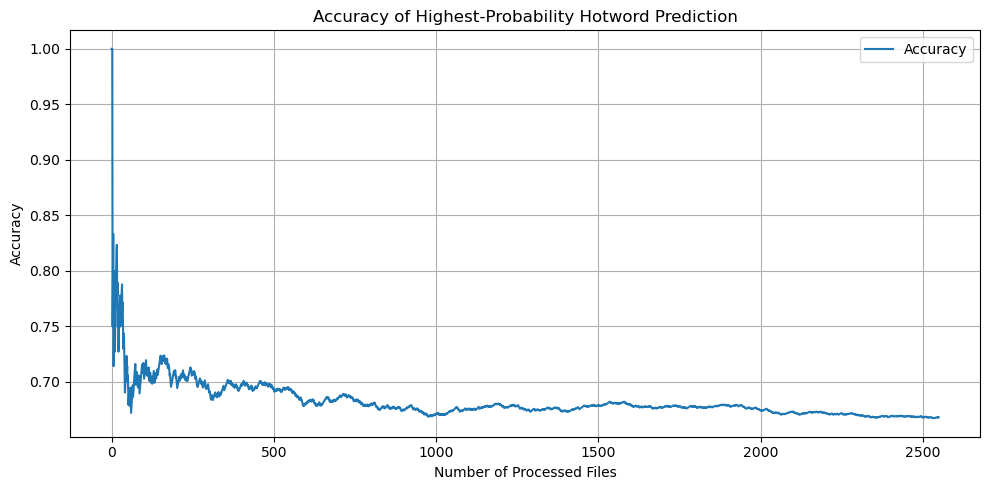

Saved results to batch_results.json


In [ ]:
import os
import json
import time
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt

# === CONFIGURATION ===
batch_size = 100
cooldown_seconds = 30  # Sleep between batches
sampling_rate = 16000

# === INIT VARIABLES ===
file_list = [f for f in os.listdir(wav_path_kid) if f.endswith('.wav')]
total_batches = len(file_list) // batch_size + 1

count = 0
correct_predictions = 0
total_predictions = 0
accuracy_over_time = []

# Track each line's result
results_data = []
line_id = 1

# Acceptable variants for targets
acceptable_variants = {
    "sun": {"sun", "son"},
    "one": {"one", "won"},
    "socks": {"socks", "sox"},
    "shoe": {"shoe", "shoo", "shue"},
}

# === MAIN LOOP ===
for batch_idx in range(total_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(file_list))
    batch_files = file_list[start_idx:end_idx]

    print(f"\n--- Processing batch {batch_idx + 1}/{total_batches} ---\n")

    for file_name in batch_files:
        if file_name in audio_files: 
            file_path = os.path.join(wav_path_kid, file_name)

            try:
                count += 1
                audio_input, _ = librosa.load(file_path, sr=sampling_rate)
                target = extract_target_word(file_name)
                ind_list, decoder, norm_decoder = preprocess(target)

                input_values = whisper_large_proc(
                    audio_input,
                    sampling_rate=sampling_rate,
                    return_tensors="pt",
                    language="en"
                ).input_features

                with torch.no_grad():
                    predicted_ids = whisper_large_model.generate(
                        input_values,
                        return_dict_in_generate=True,
                        output_scores=True
                    )

                comp = torch.stack(list(predicted_ids.scores), dim=0).squeeze()
                logits = torch.exp(comp).cpu().detach().numpy()
                reduced_logits = logits[:, ind_list]

                norm_transcription = norm_decoder.decode(
                    reduced_logits
                )

                norm_text = clean(norm_transcription).strip()

                print(norm_text)

                transcription = decoder.decode(
                    reduced_logits,
                    hotwords=hotwords,
                    hotword_weight=100.0
                )

                text = clean(transcription).strip()

                new_tries = decoder.decode_beams(
                    reduced_logits,
                    hotword_weight=100.0,
                    beam_width=100,
                    token_min_logp=-100000,
                    beam_prune_logp=-100000
                )

                target_hotwords = hotwords[target]
                h_prob_dict = {h: 0 for h in target_hotwords}

                for k in new_tries:
                    cleaned_word = clean(k[0])
                    if cleaned_word in target_hotwords:
                        h_prob_dict[cleaned_word] += np.exp(k[3])

                # Accuracy Tracking
                if h_prob_dict:
                    epsilon = 1e-6
                    all_zero_probs = all(prob < epsilon for prob in h_prob_dict.values())

                    if not all_zero_probs:
                        highest_word = max(h_prob_dict, key=h_prob_dict.get)
                        total_predictions += 1

                        if target in acceptable_variants:
                            is_accurate = int(highest_word in acceptable_variants[target])
                        else:
                            is_accurate = int(highest_word == target)

                        correct_predictions += is_accurate
                        current_accuracy = correct_predictions / total_predictions
                        accuracy_over_time.append(current_accuracy)
                    else:
                        highest_word = None
                        is_accurate = 0
                        total_predictions += 1
                        current_accuracy = correct_predictions / total_predictions
                        accuracy_over_time.append(current_accuracy)

                    # Store line result
                    results_data.append({
                        "line_id": line_id,
                        "file_name": file_name,
                        "free_transcription": norm_text, 
                        "prob_output": {k: float(v) for k, v in h_prob_dict.items()},
                        "accurate": is_accurate
                    })
                    line_id += 1

                print(f"{target} → {h_prob_dict}")

            except Exception as e:
                print(f'Error processing file {file_name}: {e}')

        # Cool down
        print("Cooling down...")
        time.sleep(cooldown_seconds)

# === PLOT ACCURACY ===
plt.figure(figsize=(10, 5))
plt.plot(accuracy_over_time, label='Accuracy')
plt.xlabel('Number of Processed Files')
plt.ylabel('Accuracy')
plt.title('Accuracy of Highest-Probability Hotword Prediction')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === SAVE RESULTS TO JSON ===
with open("batch_results.json", "w") as f:
    json.dump(results_data, f, indent=4)
print("Saved results to batch_results.json")